In [1]:
# imports

import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline  


In [2]:
### Calibrator
import glob
from calibrator import Calibrator

calibration_images = []
for file in glob.glob("camera_cal/calibration*.jpg"):
    img = mpimg.imread(file)
    calibration_images.append(img)

print("got calibration images")
calibrator = Calibrator(calibration_images,9,6)
print("created calibrator")


test_images = []
for file in glob.glob("test_images/*.jpg"):
    img = mpimg.imread(file)
    test_images.append(img)
print("got test images")

   
calibrated_images = []
for img in test_images:
    calibrated = calibrator.undistort(img)
    calibrated_images.append(calibrated)

print("calibrated test images")


got calibration images
created calibrator
got test images
calibrated test images


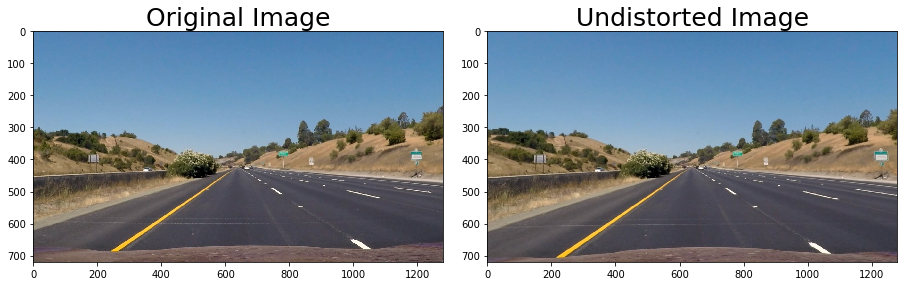

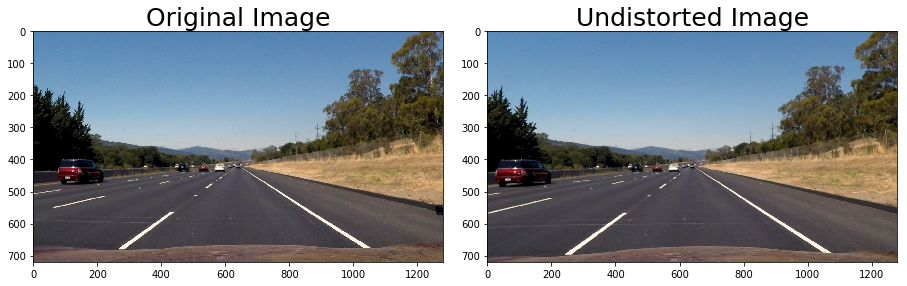

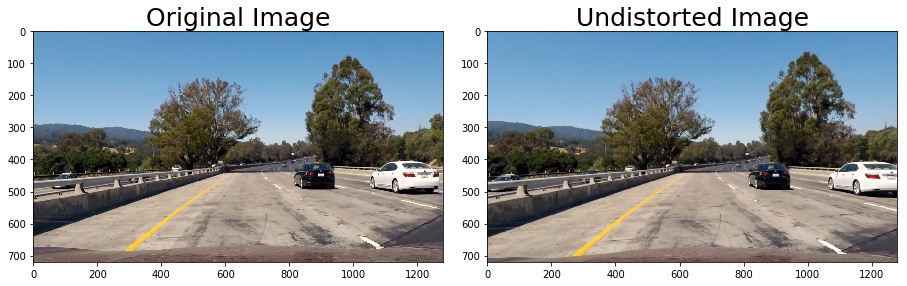

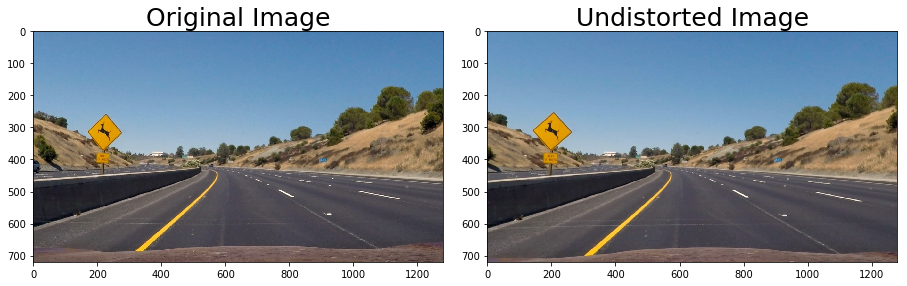

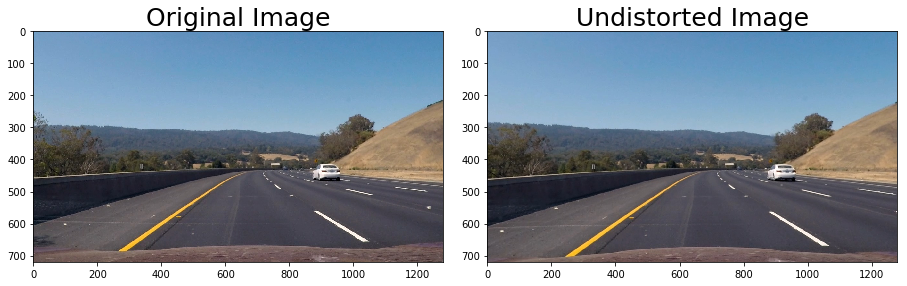

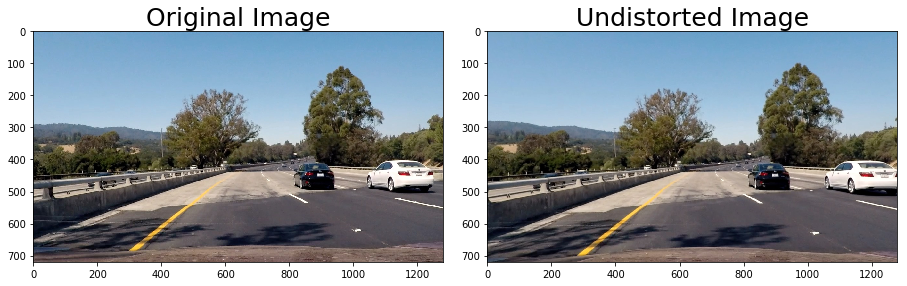

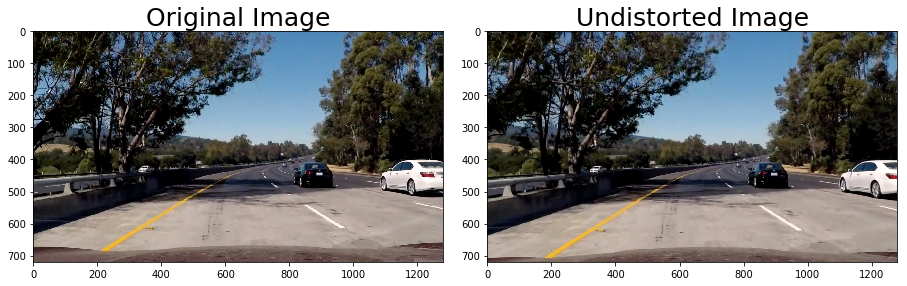

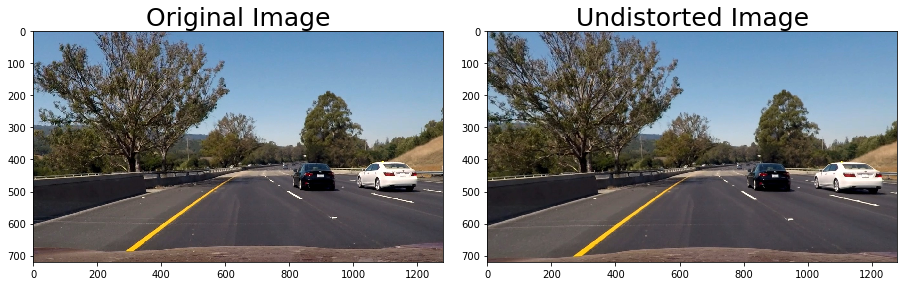

In [3]:
for i in range(len(calibrated_images)):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    f.tight_layout()
    ax1.imshow(test_images[i])
    ax1.set_title('Original Image', fontsize=25)
    ax2.imshow(calibrated_images[i])
    ax2.set_title('Undistorted Image', fontsize=25)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)



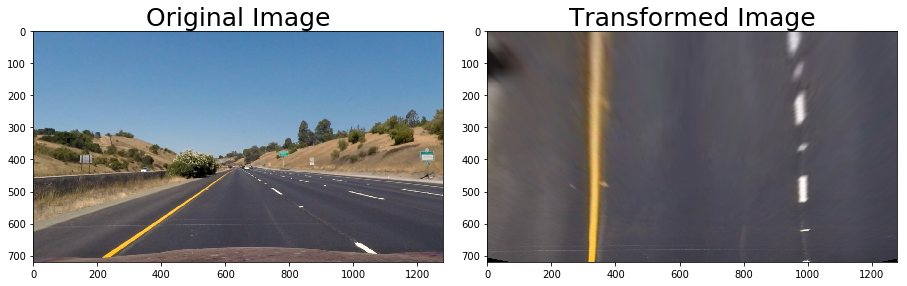

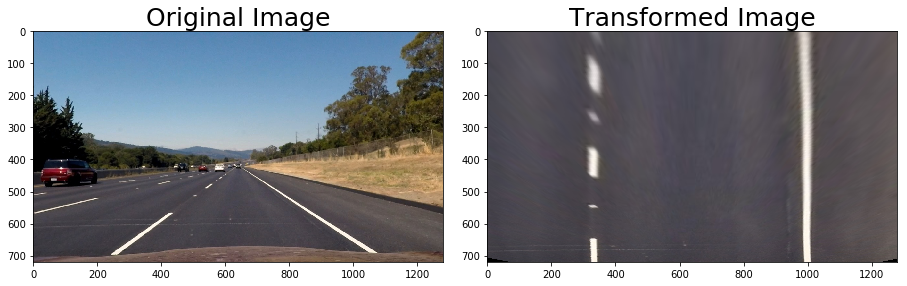

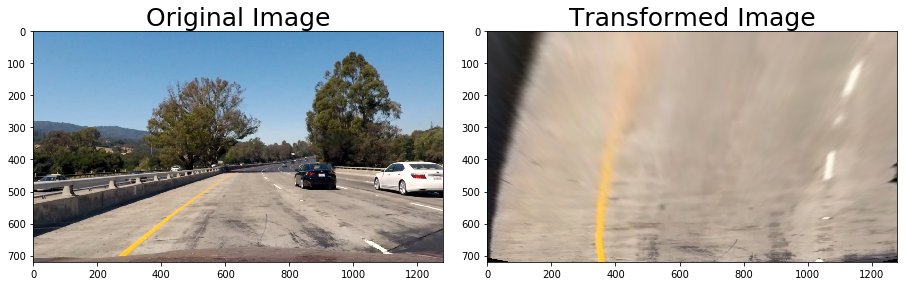

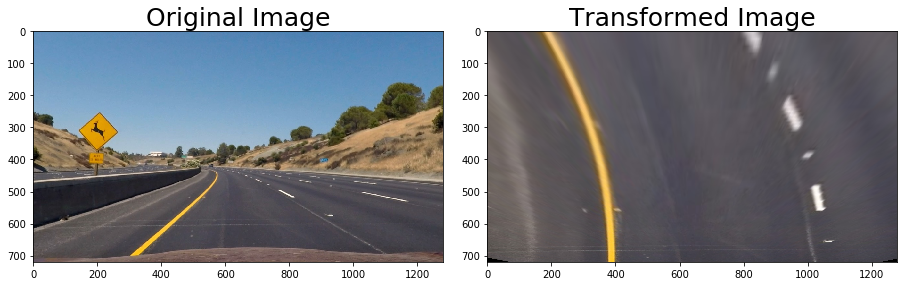

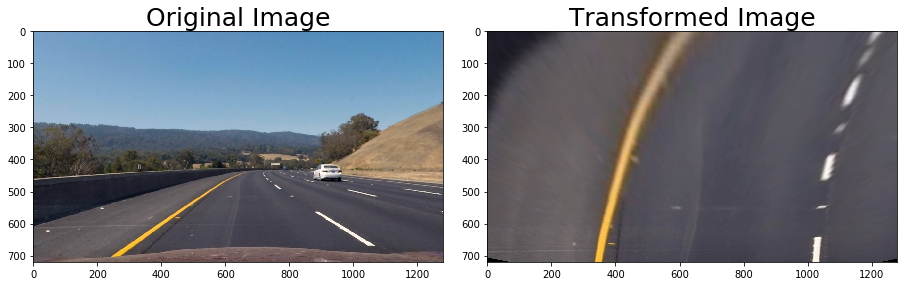

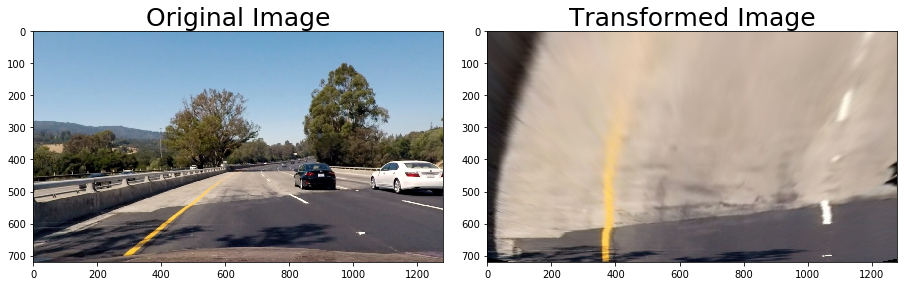

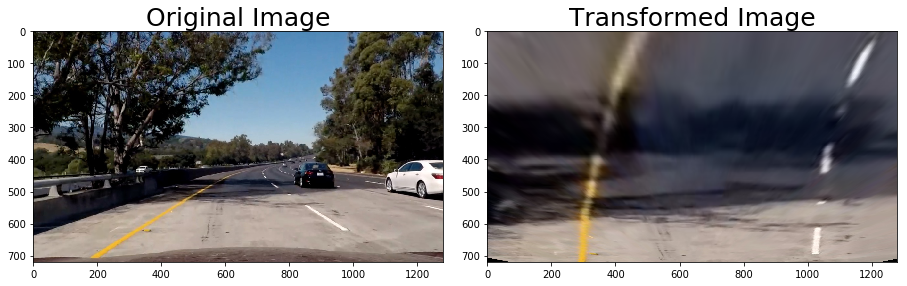

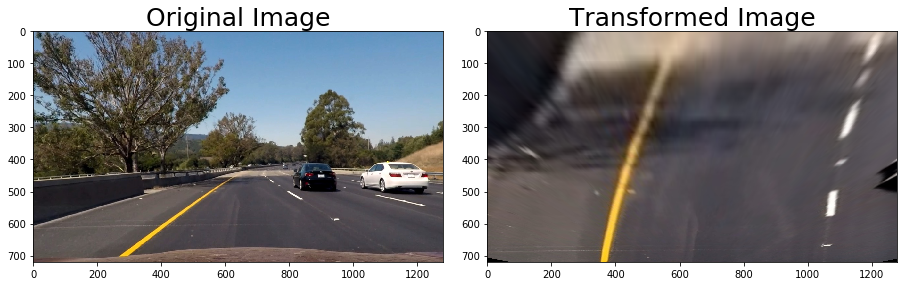

In [26]:
### Transformer
#from lane_warp import Transformer

class Transformer:
    
    trap = np.array([[250,670],[(1280/2)-50,450],[(1280/2)+50,450],[1280-250,670]],dtype=np.int32)
    dst = np.array([[300,720],[300,0],[1000,0],[1000,720]],dtype=np.int32)


    #def __init__(self):
                
                
    def transform(self,img):

        src = np.float32(self.trap)

        dst = np.float32(self.dst)

        M = cv2.getPerspectiveTransform(src, dst)

        warped = cv2.warpPerspective(img, M, (img.shape[1],img.shape[0]), flags=cv2.INTER_LINEAR)

        return warped

    def inverse_transform(self,img):

        src = np.float32(self.trap)

        dst = np.float32(self.dst)

        M = cv2.getPerspectiveTransform(dst, src)

        warped = cv2.warpPerspective(img, M, (img.shape[1],img.shape[0]), flags=cv2.INTER_LINEAR)

        return warped



transformer = Transformer()

# straight_test_images = []
# for file in glob.glob("test_images/straight*.jpg"):
#     img = mpimg.imread(file)
#     straight_test_images.append(img)
    
# straight_undistorted = []
# for img in straight_test_images:
#     calibrated = calibrator.undistort(img)
#     straight_undistorted.append(calibrated)

transformed_images = []
for img in calibrated_images:
    transformed = transformer.transform(img)
    transformed_images.append(transformed)

for i in range(len(calibrated_images)):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    f.tight_layout()
    ax1.imshow(calibrated_images[i])
    ax1.set_title('Original Image', fontsize=25)
    ax2.imshow(transformed_images[i])
    ax2.set_title('Transformed Image', fontsize=25)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)



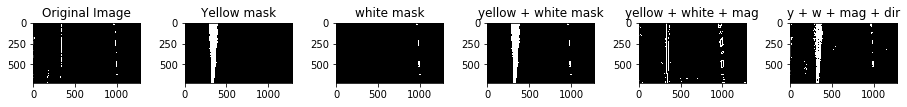

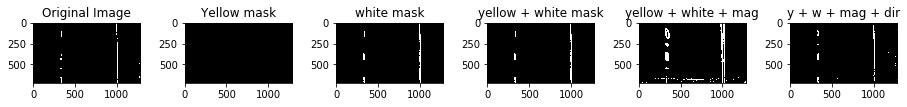

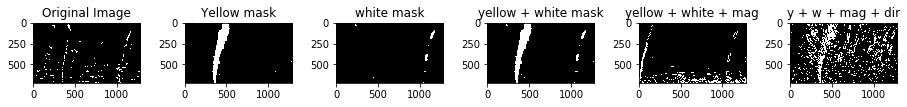

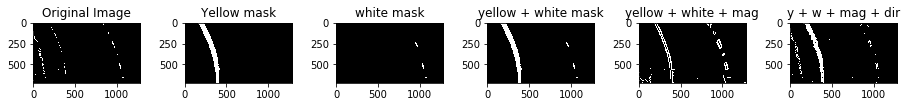

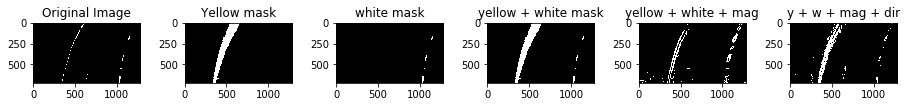

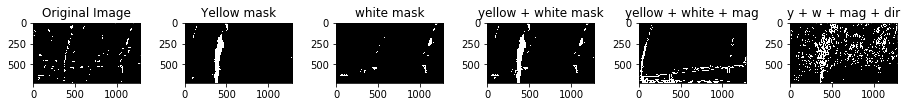

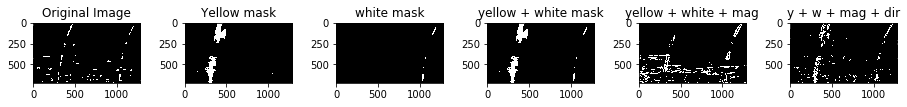

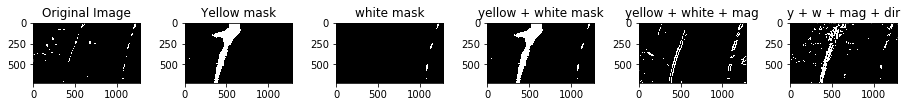

In [70]:
### Lane Thresholder

class LaneMasker:
    
    def mask(self, img):
        mag = self.mag_threshold(img, sobel_kernel=3, mag_thresh=(1, 255))
        yellow = self.yellow_filter(img)
        dir_t = self.dir_threshold(img, sobel_kernel=15, thresh=(-0.8,0.8)) 
        white = self.white_filter(img)

        yellow_and_white = np.zeros_like(mag)
        yellow_and_white[(yellow > 0) | (white > 0)] = 1

        yellow_and_white_mag = np.zeros_like(mag)
        yellow_and_white_mag[(yellow_and_white > 0) & mag > 0] = 1

        binary = np.zeros_like(mag)
        binary[(dir_t > 0) & (yellow_and_white_mag > 0)] = 1

        return binary
    
    def mag_threshold(self,img, sobel_kernel=3, mag_thresh=(0, 255)):
        # Convert to grayscale
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        # Take both Sobel x and y gradients
        sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
        sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
        # Calculate the gradient magnitude
        gradmag = np.sqrt(sobelx**2 + sobely**2)
        # Rescale to 8 bit
        scale_factor = np.max(gradmag)/255 
        gradmag = (gradmag/scale_factor).astype(np.uint8) 
        # Create a binary image of ones where threshold is met, zeros otherwise
        binary_output = np.zeros_like(gradmag)
        binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1
        # Return the binary image
        return binary_output
    
    def yellow_filter(self,img):
        hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        # define range of blue color in HSV
        lower_blue = np.array([0,60,60])
        upper_blue = np.array([50,255,255])
        # Threshold the HSV image to get only blue colors
        mask = cv2.inRange(hsv, lower_blue, upper_blue)

        H = hsv[:,:,0]
        S = hsv[:,:,1]
        V = hsv[:,:,2]
        

        thresh = (17, 40)
        binary = np.zeros_like(H)
        binary[(H > thresh[0]) & (H <= thresh[1])] = 1
        return mask
    
    def white_filter(self,img):
        hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

        # define range of white color in HSV
        # change it according to your need !
        sensitivity = 40
        lower_white = np.array([0,0,255-sensitivity])
        upper_white = np.array([255,sensitivity,255])

        # Threshold the HSV image to get only white colors
        mask = cv2.inRange(hsv, lower_white, upper_white)

        return mask



    def dir_threshold(self,img, sobel_kernel=3, thresh=(0, np.pi/2)):
        # Grayscale
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        # Calculate the x and y gradients
        sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
        sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
        # Take the absolute value of the gradient direction, 
        # apply a threshold, and create a binary image result
        absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
        binary_output =  np.zeros_like(absgraddir)
        binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

        # Return the binary image
        return binary_output

    def s_bin(self,img):
        hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        H = hls[:,:,0]
        L = hls[:,:,1]
        S = hls[:,:,2]

        thresh = (90, 200)
        binary = np.zeros_like(S)
        binary[(S > thresh[0]) & (S <= thresh[1])] = 1
        return binary



        

lanemasker = LaneMasker()

masked_images = []
for img in transformed_images:
    binary = lanemasker.mask(img)
    masked_images.append(binary)


for i in range(len(calibrated_images)):
    
    img = transformed_images[i]
    
    mag = lanemasker.mag_threshold(img, sobel_kernel=3, mag_thresh=(1, 255))
    yellow = lanemasker.yellow_filter(img)
    dir_t = lanemasker.dir_threshold(img, sobel_kernel=15, thresh=(-0.8,0.8)) 
    s_thresh = lanemasker.s_bin(img) 
    white = lanemasker.white_filter(img)
    
    yellow_and_white = np.zeros_like(mag)
    yellow_and_white[(yellow > 0) | (white > 0)] = 1
    
    yellow_and_white_mag = np.zeros_like(mag)
    yellow_and_white_mag[(yellow_and_white > 0) & mag > 0] = 1
    
    binary = np.zeros_like(mag)
    binary[(dir_t > 0) & (yellow_and_white_mag > 0)] = 1

    
    f, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(1, 6, figsize=(12, 5))
    f.tight_layout()
    ax1.imshow(img)
    ax1.set_title('Original Image')
    ax2.imshow(yellow, cmap = "gray")
    ax2.set_title('Yellow mask')
    ax3.imshow(white, cmap = "gray")
    ax3.set_title('white mask')
    ax4.imshow(yellow_and_white, cmap = "gray")
    ax4.set_title('yellow + white mask')
    ax5.imshow(yellow_and_white_mag, cmap = "gray")
    ax5.set_title('yellow + white + mag')
    ax6.imshow(masked_images[i], cmap = "gray")
    ax6.set_title('y + w + mag + dir')



    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)




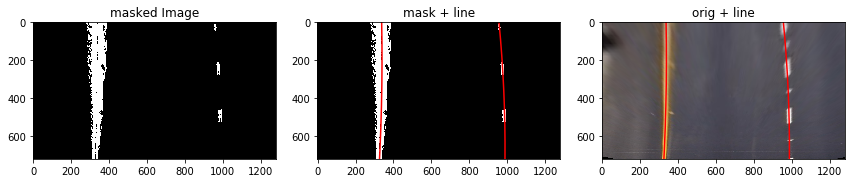

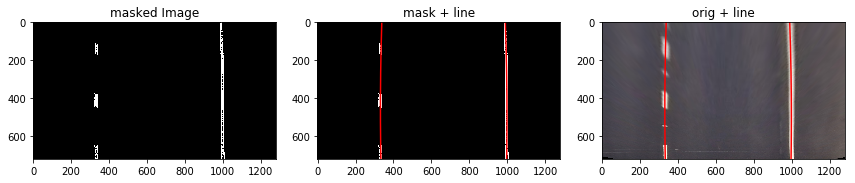

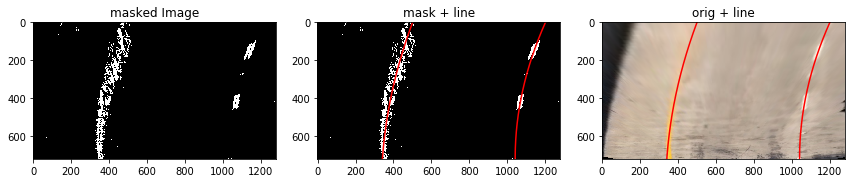

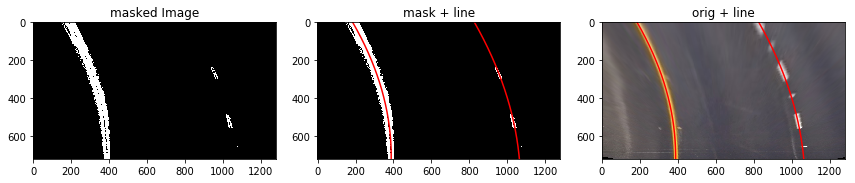

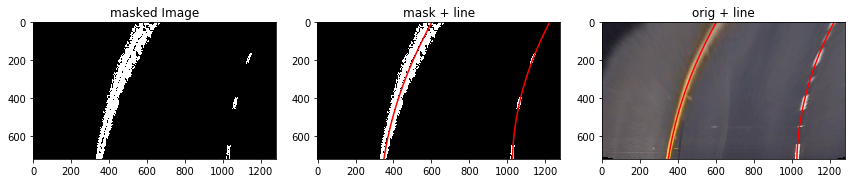

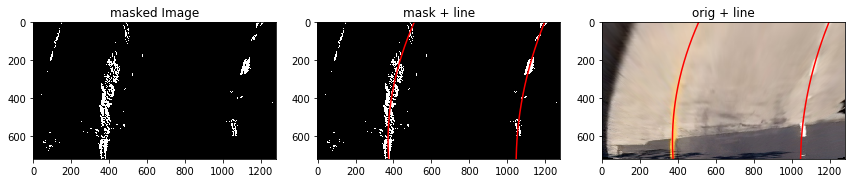

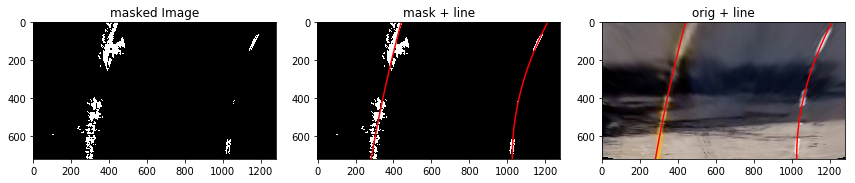

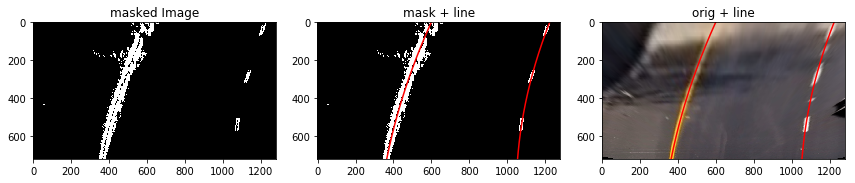

In [28]:
### Line Finder

class LineFinder:
    def line_equations(self,img):
        histogram = np.sum(img[int(img.shape[0]/2):,:], axis=0)
        # Create an output image to draw on and  visualize the result
        out_img = np.dstack((img, img, img))*255
        # Find the peak of the left and right halves of the histogram
        # These will be the starting point for the left and right lines
        midpoint = np.int(histogram.shape[0]/2)
        leftx_base = np.argmax(histogram[:midpoint])
        rightx_base = np.argmax(histogram[midpoint:]) + midpoint

        # Choose the number of sliding windows
        nwindows = 9
        # Set height of windows
        window_height = np.int(img.shape[0]/nwindows)
        # Identify the x and y positions of all nonzero pixels in the image
        nonzero = img.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Current positions to be updated for each window
        leftx_current = leftx_base
        rightx_current = rightx_base
        # Set the width of the windows +/- margin
        margin = 100
        # Set minimum number of pixels found to recenter window
        minpix = 50
        # Create empty lists to receive left and right lane pixel indices
        left_lane_inds = []
        right_lane_inds = []

        # Step through the windows one by one
        for window in range(nwindows):
            # Identify window boundaries in x and y (and right and left)
            win_y_low = img.shape[0] - (window+1)*window_height
            win_y_high = img.shape[0] - window*window_height
            win_xleft_low = leftx_current - margin
            win_xleft_high = leftx_current + margin
            win_xright_low = rightx_current - margin
            win_xright_high = rightx_current + margin
            # Draw the windows on the visualization image
            cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
            cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
            # Identify the nonzero pixels in x and y within the window
            good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
            good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
            # Append these indices to the lists
            left_lane_inds.append(good_left_inds)
            right_lane_inds.append(good_right_inds)
            # If you found > minpix pixels, recenter next window on their mean position
            if len(good_left_inds) > minpix:
                leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
            if len(good_right_inds) > minpix:        
                rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

        # Concatenate the arrays of indices
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)

        # Extract left and right line pixel positions
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds] 
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds] 

        # Fit a second order polynomial to each
        left_fit = np.polyfit(lefty, leftx, 2)
        right_fit = np.polyfit(righty, rightx, 2)

        return left_fit, right_fit

        
# window settings
window_width = 60 
window_height = 120 # Break image into 9 vertical layers since image height is 720
margin = 100 # How much to slide left and right for searching

lineFinder = LineFinder()

for i in range(len(masked_images)):
    masked = masked_images[i]
    orig = transformed_images[i]
    left_fit, right_fit = lineFinder.line_equations(masked)

    ploty = np.linspace(0, masked.shape[0]-1, masked.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
        # Create an image to draw the lines on
    warp_zero = np.zeros_like(masked).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 5))
    f.tight_layout()
    ax1.imshow(masked, cmap = 'gray')
    ax1.set_title('masked Image')
    
    
    ax2.imshow(masked, cmap="gray")
    ax2.plot(left_fitx, ploty, color='red')
    ax2.plot(right_fitx, ploty, color='red')
    ax2.set_title('mask + line')

    ax3.imshow(orig)
    ax3.set_title('orig + line')
    ax3.plot(left_fitx, ploty, color='red')
    ax3.plot(right_fitx, ploty, color='red')





2964.99105321 1581.64463106
908.643921858 m 518.443152226 m


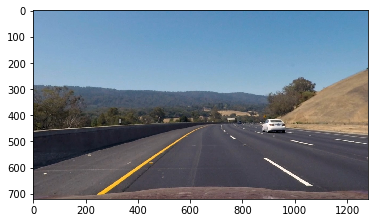

In [81]:
### Curvature finder

def curvature(f1,f2):
    return

masked = masked_images[4]
left_fit, right_fit = lineFinder.line_equations(masked)

left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
# Fit new polynomials to x,y in world space
left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)
# Calculate the new radii of curvature
left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
# Now our radius of curvature is in meters
print(left_curverad, 'm', right_curverad, 'm')



ploty = np.linspace(0, masked.shape[0]-1, masked.shape[0] )

y_eval = np.max(ploty)

left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
print(left_curverad, right_curverad)

plt.imshow(calibrated_images[4])

ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension





In [30]:
### Center offset finder

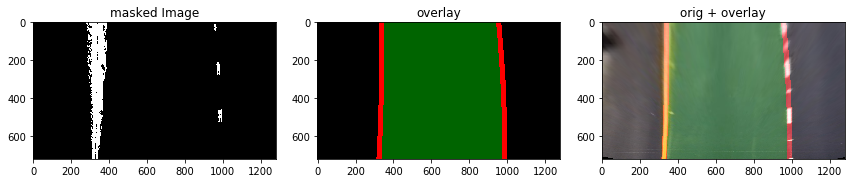

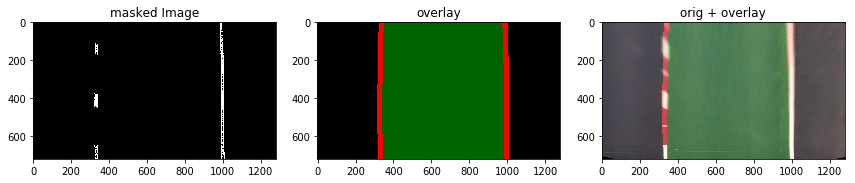

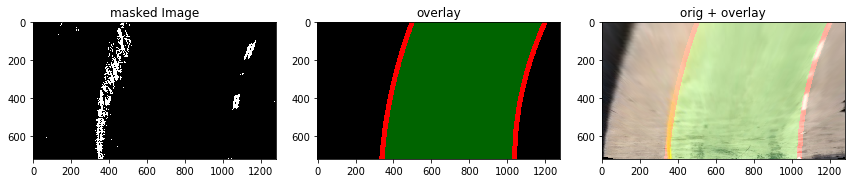

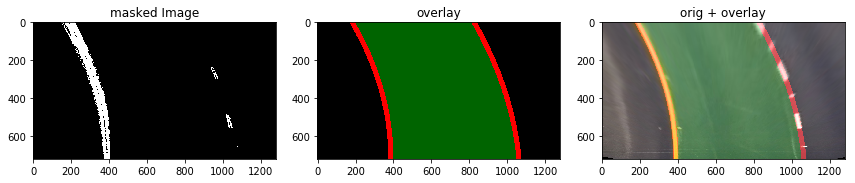

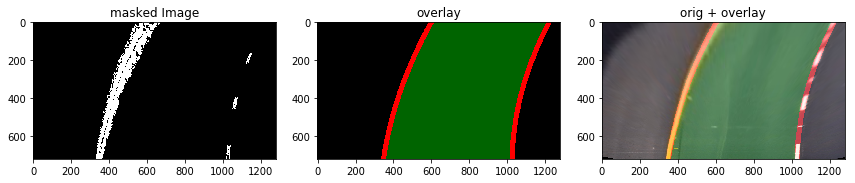

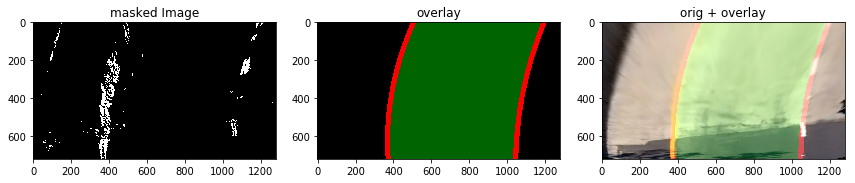

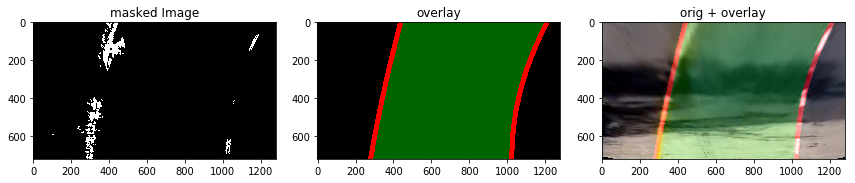

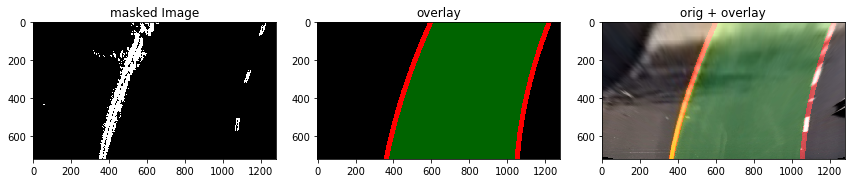

In [33]:
### Overlay generator

class OverlayGenerator:
    def generate_overlay(self,left_fit,right_fit,img_size,c1=[100,0,0],c2=[0,100,0],c3=[0,0,100]):
            ploty = np.linspace(0, masked.shape[0]-1, masked.shape[0] )
            left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
            right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

            # Create an image to draw the lines on
            overlay = np.zeros((img_size)).astype(np.uint8)
            overlay = np.dstack((overlay, overlay, overlay))

            # Recast the x and y points into usable format for cv2.fillPoly()
            pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
            pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
            pts = np.hstack((pts_left, pts_right))
            
            r_line_pts = pts_right.reshape((-1,1,2))
            l_line_pts = pts_left.reshape((-1,1,2))
            # Draw the lane onto the warped blank image
            cv2.fillPoly(overlay, np.int_([pts]), (0,100, 0))
            cv2.polylines(overlay,np.int_([r_line_pts]),False,(255,0,0), 25)
            cv2.polylines(overlay,np.int_([l_line_pts]),False,(255,0,0), 25)
            return overlay

gen = OverlayGenerator()

for i in range(len(masked_images)):
    masked = masked_images[i]
    orig = transformed_images[i]
    left_fit, right_fit = lineFinder.line_equations(masked)
    overlay = gen.generate_overlay(left_fit, right_fit,masked.shape)

    f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 5))
    f.tight_layout()
    ax1.imshow(masked, cmap = 'gray')
    ax1.set_title('masked Image')
    
    ax2.imshow(overlay)
    ax2.set_title('overlay')
    
    both = cv2.addWeighted(orig, 1, overlay, 0.5, 0)

    ax3.imshow(both)
    ax3.set_title('orig + overlay')



        

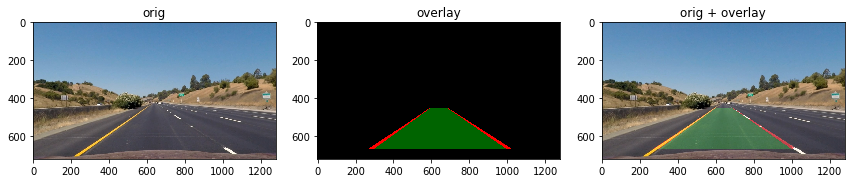

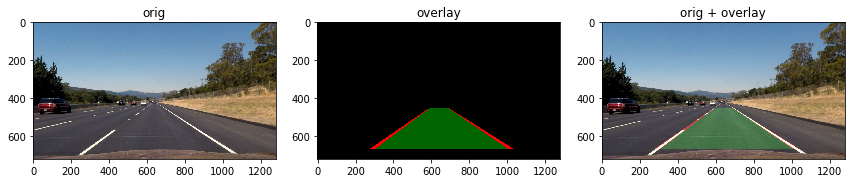

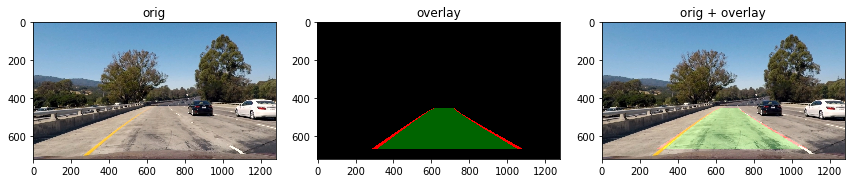

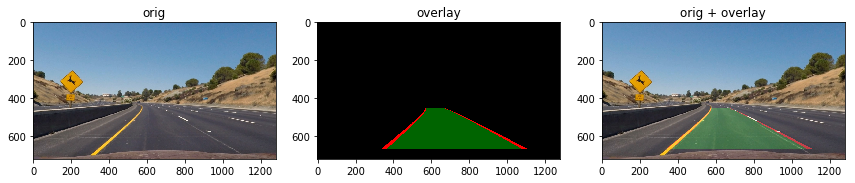

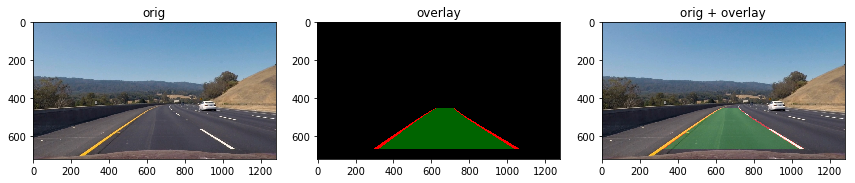

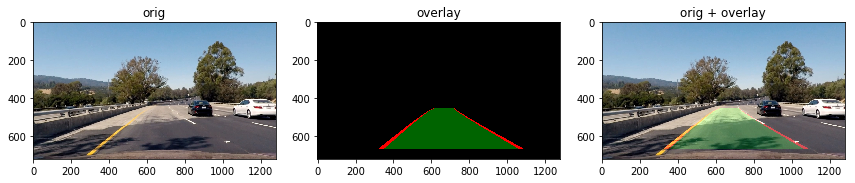

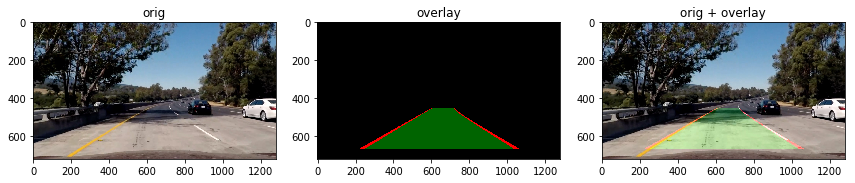

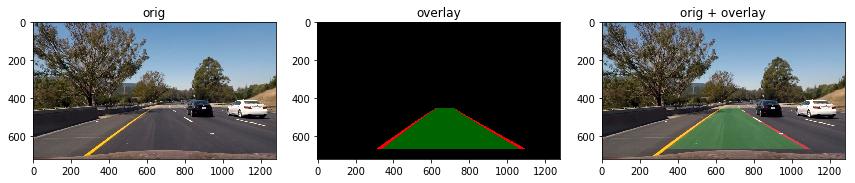

In [34]:
### untransformer

for i in range(len(masked_images)):
    masked = masked_images[i]
    orig = calibrated_images[i]
    left_fit, right_fit = lineFinder.line_equations(masked)
    overlay = transformer.inverse_transform(gen.generate_overlay(left_fit, right_fit,masked.shape))

    f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 5))
    f.tight_layout()
    ax1.imshow(orig, cmap = 'gray')
    ax1.set_title('orig')
    
    ax2.imshow(overlay)
    ax2.set_title('overlay')
    
    both = cv2.addWeighted(orig, 1, overlay, 0.5, 0)

    ax3.imshow(both)
    ax3.set_title('orig + overlay')



In [14]:
### Combine overlay and original

In [85]:
### full pipeline lane marker
from moviepy.editor import VideoFileClip
from IPython.display import HTML

lanemasker = LaneMasker()

def process_image(img):
    undist = calibrator.undistort(img)
    transformed = transformer.transform(undist)
    masked = lanemasker.mask(transformed)
    left_fit, right_fit = lineFinder.line_equations(masked)
    overlay = gen.generate_overlay(left_fit, right_fit,masked.shape)
    overlay_undist = transformer.inverse_transform(overlay)
    both = cv2.addWeighted(undist, 1, overlay_undist, 0.5, 0)
    
    left_fit, right_fit = lineFinder.line_equations(masked)

    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    # Now our radius of curvature is in meters
    font = cv2.FONT_HERSHEY_COMPLEX    

    cv2.putText(both, "left {0} right {1}".format(left_curverad, right_curverad), (30, 60), font, 1, (0,255,0), 2)
        
    return both

yellow_output = 'proj.mp4'
clip2 = VideoFileClip('project_video.mp4').subclip(27,33)
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video proj.mp4
[MoviePy] Writing video proj.mp4





  0%|          | 0/151 [00:00<?, ?it/s]


  1%|          | 1/151 [00:00<01:43,  1.45it/s]


  1%|▏         | 2/151 [00:01<01:40,  1.48it/s]


  2%|▏         | 3/151 [00:02<01:40,  1.47it/s]


  3%|▎         | 4/151 [00:02<01:39,  1.48it/s]


  3%|▎         | 5/151 [00:03<01:37,  1.50it/s]


  4%|▍         | 6/151 [00:03<01:34,  1.53it/s]



  5%|▍         | 7/151 [00:04<01:34,  1.53it/s]

  5%|▌         | 8/151 [00:05<01:34,  1.52it/s]

  6%|▌         | 9/151 [00:05<01:33,  1.52it/s]

  7%|▋         | 10/151 [00:06<01:32,  1.53it/s]

  7%|▋         | 11/151 [00:07<01:31,  1.54it/s]

  8%|▊         | 12/151 [00:07<01:29,  1.55it/s]

  9%|▊         | 13/151 [00:08<01:27,  1.57it/s]

  9%|▉         | 14/151 [00:09<01:27,  1.57it/s]

 10%|▉         | 15/151 [00:09<01:26,  1.57it/s]

 11%|█         | 16/151 [00:10<01:26,  1.56it/s]

 11%|█▏        | 17/151 [00:11<01:25,  1.56it/s]

 12%|█▏        | 18/151 [00:11<01:25,  1.56it/s]

 13%|█▎        | 19/151 [00:12<01:24,  1.57it/s]

 13%|█▎

[MoviePy] Done.
[MoviePy] >>>> Video ready: proj.mp4 

CPU times: user 1min 45s, sys: 570 ms, total: 1min 46s
Wall time: 1min 38s


In [86]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))